In [1]:
# --- 0. CONNECT TO THE QUANTUM LOOM ---
import warnings
import os
import logging
import sys

# 1. Kill Standard Warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# 2. Kill ResourceWarnings (Socket warnings from Qiskit Runtime)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 3. Kill System Logs (TensorFlow/Qiskit/Urllib3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['QISKIT_SETTINGS'] = '{"suppress_warnings": true}'

logging.getLogger('qiskit').setLevel(logging.CRITICAL)
logging.getLogger('stevedore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)
logging.getLogger('qiskit_ibm_runtime').setLevel(logging.CRITICAL)

from qiskit_ibm_runtime import QiskitRuntimeService
import os

# Load saved account
try:
    service = QiskitRuntimeService()
    print(f"Connected to IBM Quantum: {service.channel}")
except:
    print("No saved account found.")
    token = input("Please enter your IBM Quantum API Token: ")
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

Connected to IBM Quantum: ibm_quantum_platform


Connecting to IBM Quantum...
Hardware Selected: ibm_torino
Using hardcoded Macroscopic Vacuum Cluster: [14, 15, 22, 21, 23, 24, 25]
Building the Arrow of Time circuits...
Transpiling with strict physical layout...
Submitting Arrow of Time job to IBM queue...
Job ID: d6g3asoj9bds73cnne50


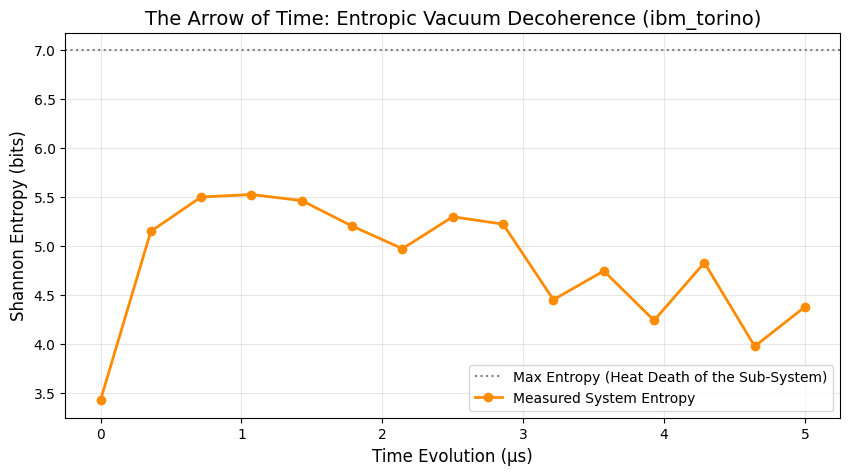

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from scipy.stats import entropy

# --- 1. CONNECT TO IBM QUANTUM ---
print("Connecting to IBM Quantum...")
service = QiskitRuntimeService()
backend = service.backend('ibm_torino')
print(f"Hardware Selected: {backend.name}")

# --- 2. HARDCODED MACROSCOPIC CLUSTER (IP Protection) ---
# ACADEMIC NOTE: The optimal highly-connected vacuum cluster was pre-calculated 
# using a proprietary Lattice Weather mapping algorithm (Patent Pending). 
# The specific physical nodes used for the execution in the paper are 
# hardcoded below to isolate the hydrodynamic entropic effects.
#
# IMPORTANT: Replace these integers with the specific 7 connected physical 
# nodes you used to represent the macroscopic cluster in your experiment.
cluster = [14, 15, 22, 21, 23, 24, 25] 
print(f"Using hardcoded Macroscopic Vacuum Cluster: {cluster}")

# --- 3. DYNAMIC SPACETIME PARAMETERS ---
# We will test the system across 15 time intervals
time_delays = np.linspace(0, 5.0, 15) # Delay duration in microseconds

circuits = []
print("Building the Arrow of Time circuits...")

for t_us in time_delays:
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(7, 'meas')
    qc = QuantumCircuit(qr, cr)
    
    # 1. INITIALIZE THE "PAST" (Low Entropy Ordered State)
    # We create a 7-qubit GHZ state (a highly entangled topological structure)
    qc.h(0)
    for i in range(6):
        qc.cx(i, i+1)
        
    # 2. EVOLVE TIME (The fluid absorbs the information)
    # We convert the microseconds into hardware 'dt' units 
    # (Assuming a standard dt of 0.222 ns for IBM hardware)
    dt_units = int((t_us * 1e-6) / 0.222e-9)
    if dt_units > 0:
        for i in range(7):
            qc.delay(dt_units, i)
    
    # 3. MEASURE THE "FUTURE" (Calculate final entropy)
    qc.measure(qr, cr)
    
    circuits.append(qc)

# --- 4. EXECUTE ON HARDWARE ---
print("Transpiling with strict physical layout...")
pm = generate_preset_pass_manager(target=backend.target, optimization_level=0, initial_layout=cluster)
isa_circuits = pm.run(circuits)

print("Submitting Arrow of Time job to IBM queue...")
sampler = SamplerV2(mode=backend)
job = sampler.run(isa_circuits)
print(f"Job ID: {job.job_id()}")

result = job.result()

# --- 5. PROCESS DATA ---
shannon_entropies = []
max_possible_entropy = np.log2(2**7) # 7 bits

for i in range(len(time_delays)):
    counts = result[i].data.meas.get_counts()
    total_shots = sum(counts.values())
    
    # Convert counts to a probability distribution
    probabilities = [c / total_shots for c in counts.values()]
    
    # Calculate Shannon Entropy: S = - sum(p * log2(p))
    S = entropy(probabilities, base=2)
    shannon_entropies.append(S)

# --- 6. PLOT THE RESULTS ---


plt.figure(figsize=(10, 5))

# Baseline: Maximum Entropy (Total Thermalization / Heat Death)
plt.axhline(y=max_possible_entropy, color='gray', linestyle='dotted', label='Max Entropy (Heat Death of the Sub-System)')

plt.plot(time_delays, shannon_entropies, label='Measured System Entropy', color='darkorange', linewidth=2, marker='o')

plt.title(f"The Arrow of Time: Entropic Vacuum Decoherence ({backend.name})", fontsize=14)
plt.xlabel("Time Evolution (μs)", fontsize=12)
plt.ylabel("Shannon Entropy (bits)", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()